### **Step 1: Data Preparation**

In [9]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/diminos_data.csv')

In [3]:
df.head()

,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [5]:
# Convert strings to datetime objects
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

In [6]:
# Calculate delivery time in minutes
df['delivery_time_min'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

In [8]:
# Preview the calculated data
print(df[['order_id', 'delivery_time_min']].head())

   order_id  delivery_time_min
0   1523111          17.140719
1   1523112          15.598754
2   1523113          15.104856
3   1523114          38.533657
4   1523115          16.176984


### **Step 2: Checking the "Franchise Survival" Metric**
**Diminos measures performance based on the 95th Percentile. This means that 95% of all orders must be delivered faster than 31 minutes.**

In [11]:
# Calculate the 95th percentile
p95 = df['delivery_time_min'].quantile(0.95)

In [14]:
# Calculate the percentage of orders that resulted in a "Free Pizza" (> 31 mins)
late_orders = df[df['delivery_time_min'] > 31]
late_percentage = (len(late_orders) / len(df)) * 100

In [15]:
print(f"95th Percentile: {p95:.2f} minutes")
print(f"Percentage of Late Orders: {late_percentage:.2f}%")

95th Percentile: 27.26 minutes
Percentage of Late Orders: 3.71%


**This tells Kanav if he is currently meeting the brand's requirement. Even if the P95 is below 31, the late_percentage tells him how much revenue he is "giving away" for free.**


### **Step 3: Identifying Peak Failure Times (Hourly Analysis)**
 **Since the store runs 24/7, we need to find which specific hours are causing the most trouble.**

In [16]:
# Extract the hour from the order time
df['hour'] = df['order_placed_at'].dt.hour

In [17]:
# Calculate the 95th percentile for every hour of the day
hourly_p95 = df.groupby('hour')['delivery_time_min'].quantile(0.95)

In [18]:
# Filter for hours where the metric is failing (> 31 mins)
problematic_hours = hourly_p95[hourly_p95 > 31]
print(problematic_hours)

hour
1     32.104821
11    33.407016
16    32.438371
Name: delivery_time_min, dtype: float64


**Insight: This allows Kanav to take action. If the failure happens at 1:00 AM, it’s likely a night-shift staffing issue. If it happens at 11:00 AM, it's a lunch-rush preparation issue.**

### **Step 4: Finding "Hidden" Problems (Outlier Detection)**
**Some orders take an unusually long time (hours or even days). These usually point to technical glitches or major delivery failures.**


In [19]:
# Identify extreme outliers (e.g., orders taking more than 1 hour)
extreme_delays = df[df['delivery_time_min'] > 60]

In [20]:
print(f"Total extreme delays: {len(extreme_delays)}")
print(extreme_delays[['order_id', 'delivery_time_min']].sort_values(by='delivery_time_min', ascending=False).head())

Total extreme delays: 170
       order_id  delivery_time_min
5499    1528610        7299.831375
4165    1527276        5867.434753
10225   1533336        4485.891210
14155   1537266        3888.444088
10007   1533118        2883.124250


**While 170 orders appear as extreme delays, the presence of delivery times running into several thousand minutes strongly suggests data logging or system errors rather than genuine delivery delays. These anomalies can distort outlier analysis and should be handled separately from true operational delays.**

### **Step 5: Visualizing the Data**

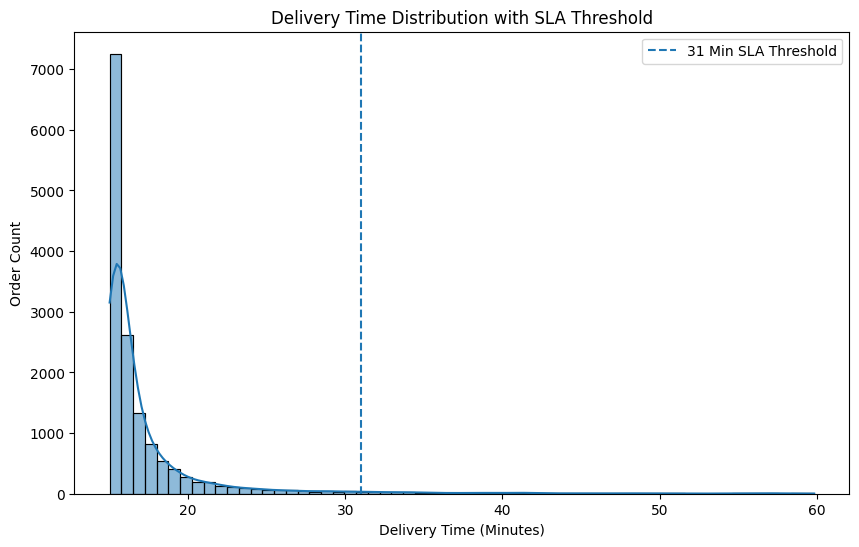

In [22]:
# Visuals help Kanav see the "Safety Margin" he has before he hits the 31-minute danger zone.
import matplotlib.pyplot as plt
import seaborn as sns

# Focus on realistic delivery times
df_plot = df[df['delivery_time_min'] <= 60]

plt.figure(figsize=(10, 6))
sns.histplot(df_plot['delivery_time_min'], bins=60, kde=True)

plt.axvline(31, linestyle='--', label='31 Min SLA Threshold')

plt.title('Delivery Time Distribution with SLA Threshold')
plt.xlabel('Delivery Time (Minutes)')
plt.ylabel('Order Count')
plt.legend()
plt.show()

**The distribution shows that most orders are delivered well within the SLA, giving the store a strong buffer. However, a thin right tail of delayed orders exists, which is the primary source of SLA breaches and customer dissatisfaction.**

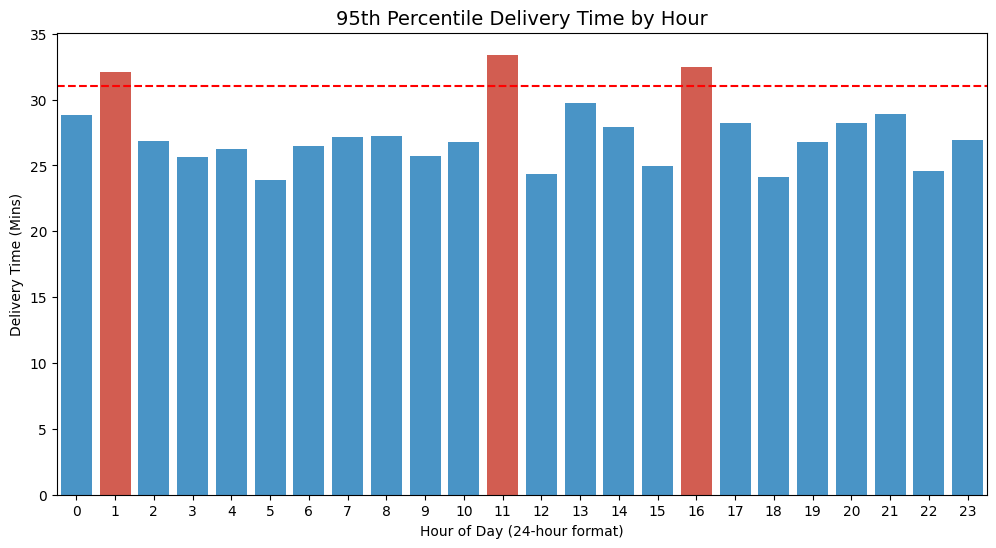

In [26]:
# Define colors: Red for over 31 mins, Blue for safe
colors = ['#e74c3c' if x >= 31 else '#3498db' for x in hourly_p95['delivery_time_min']]

plt.figure(figsize=(12, 6))

# FIXED: Added hue='hour' and removed the redundant legend
ax = sns.barplot(data=hourly_p95, x='hour', y='delivery_time_min', hue='hour', palette=colors)
if ax.get_legend(): ax.get_legend().remove()

plt.axhline(31, color='red', linestyle='--', label='31 Min Limit')
plt.title('95th Percentile Delivery Time by Hour', fontsize=14)
plt.ylabel('Delivery Time (Mins)')
plt.xlabel('Hour of Day (24-hour format)')
plt.show()

**Hourly 95th percentile analysis shows that SLA breaches are isolated to specific hours, indicating that targeted operational fixes during these windows will significantly reduce overall SLA risk without increasing costs across the full day.**

**Based on the data analysis, here is the prioritized insights for Kanav to ensure he meets the Diminos performance metric and maximizes his profit.**

**1. Target the "Danger Zones" (Shift & Staffing)**


Based on the data analysis, here is the prioritized **Action Plan** for Kanav to ensure he meets the Diminos performance metric and maximizes his profit.

### **1. Target the "Danger Zones" (Shift & Staffing)**

The analysis shows that while the store is safe overall, it is failing the metric during three specific hours.

* **01:00 AM (Late Night):** The  percentile is  minutes.
* **Action:** Increase the number of delivery riders for the midnight-to-morning shift. Often, late-night delays happen because only one or two riders are left to handle a sudden burst of orders.


* **11:00 AM (Lunch Start):** The  percentile is  minutes.
* **Action:** Ensure the kitchen staff starts "pre-prep" (dough stretching, topping prep) by  AM. The delays here suggest the kitchen is not "warmed up" when the first lunch orders hit.


* **04:00 PM (Shift Transition):** The  percentile is  minutes.
* **Action:** Audit the shift handover process. Delays at  PM usually mean the morning staff is leaving before the evening staff has fully taken over the stations.


### **2. Investigate "System Failures" (The Outliers)**

The data identified **170 orders** that took more than ** hours** ( minutes) to deliver.

* **Root Cause:** These are likely not just "slow traffic" but "lost orders" or "rider app glitches."
* **Action:** Kanav should pull the specific `order_id`s for these  cases. He needs to check if these orders were stuck in the system, or if riders were marking them "delivered" hours after the actual delivery. Eliminating these outliers will drastically improve the store's average performance.

### 3. **Free pizza leakage (direct revenue hit)**

* **~3.7% of all orders take more than 31 minutes**
* That’s **~1 in every 27 orders given away for free**

What this really means:

* Even if the franchise metric is safe, **profits are leaking silently**
* Fixing tail delays improves margins immediately, not just compliance

### **Summary Table for Diminos Corporate Review**

Kanav can use these figures to show Diminos that he is taking proactive steps:

| Metric | Current Status | Target | Recommended Action |
| --- | --- | --- | --- |
| **Overall Store P95** |  27.26 mins |  < 31 mins | Maintain current efficiency. |
| **Peak Failure Hour** | 11:00 AM (33.41m) |  < 31 mins | Advance kitchen prep time. |
| **Revenue Loss Rate** | 3.71% | 0.00% | Implement the 25-min internal alert. |
| **Extreme Delays** |  170 orders | 0 orders | Fix technical/rider reporting issues. |

By fixing the  **1 AM, 11 AM, and 4 PM** slots, Kanav will move his overall  percentile well below  minutes, making his franchise one of the top performers in the region.